In [9]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union
import yaml
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)


In [10]:
ssa_iso = ['AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CPV', 'CMR', 'CAF', 'TCD', 'COM',
           'COG', 'COD', 'CIV', 'DJI', 'GNQ', 'ERI', 'SWZ', 'ETH', 'GAB', 'GMB',
           'GHA', 'GIN', 'GNB', 'KEN', 'LSO', 'LBR', 'MDG', 'MWI', 'MLI', 'MRT',
           'MUS', 'MOZ', 'NAM', 'NER', 'NGA', 'RWA', 'STP', 'SEN', 'SYC', 'SLE',
           'SOM', 'ZAF', 'SSD', 'SDN', 'TZA', 'TGO', 'UGA', 'ZMB', 'ZWE']

In [ ]:

CPIS_path = resolve_path(config['Combined_CPIS_shp_path'])
Arid_Cropland_path = resolve_path(config['Africa_all_shp_path'])  # Path to Arid Cropland shapefile

# Load the CPIS shapefile
CPIS_gdf = gpd.read_file(CPIS_path)
print(CPIS_gdf.crs)
# Load the Arid Cropland shapefile
Arid_Cropland_gdf = gpd.read_file(Arid_Cropland_path)

# Make sure the coordinate systems are matching
CPIS_gdf.set_crs(epsg=4326, inplace=True)
Arid_Cropland_gdf.set_crs(epsg=4326, inplace=True)

# Function to check if the centroid of a geometry intersects with any features in the Arid Cropland shapefile
def check_centroid_intersect(geometry, arid_cropland_gdf):
    centroid = geometry.centroid
    return arid_cropland_gdf.geometry.intersects(centroid).any()

# Apply the function to each geometry in the CPIS GeoDataFrame with a progress bar
tqdm.pandas(desc="Checking centroids")
CPIS_gdf['centroid_in_arid_cropland'] = CPIS_gdf.geometry.progress_apply(lambda x: check_centroid_intersect(x, Arid_Cropland_gdf))

# Filter out geometries whose centroids do not intersect with the Arid Cropland
inside_cpis_gdf = CPIS_gdf[CPIS_gdf['centroid_in_arid_cropland']]

# Check the amount of data inside the Arid Cropland
inside_count = inside_cpis_gdf.shape[0]

# Print the result
print(f"Number of CPIS geometries inside the Arid Cropland: {inside_count}")

# Save the result to a new shapefile
#inside_cpis_gdf.to_file(resolve_path(config['Inside_CPIS_shp_path']))

# Plot the result
base = CPIS_gdf.plot(color='blue', edgecolor='black', alpha=0.5, figsize=(10, 10))
inside_cpis_gdf.plot(ax=base, color='green', edgecolor='black')
Arid_Cropland_gdf.plot(ax=base, color='none', edgecolor='brown')  # Add Arid Cropland boundaries for reference
plt.title(f"CPIS Geometries: Total = {len(CPIS_gdf)}, Inside Arid Zones = {inside_count}")
plt.show()


Trim CPIS into Aridity Layers and Reproject

Original CRS: EPSG:4326
Reprojected CRS: EPSG:3857


Processing CPIS Layers:   0%|          | 0/4 [00:00<?, ?it/s]

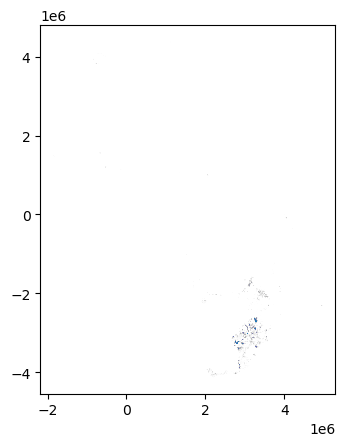

Processing CPIS Layers:  25%|██▌       | 1/4 [00:29<01:29, 29.87s/it]

CPIS data for Semi_Arid aridity layer processed and saved to /home/waves/data/Africa_Irrigation/Data/Processed/Combined_CPIS_Aridity_Layers-shp/Combined_CPIS_Semi_Arid.shp


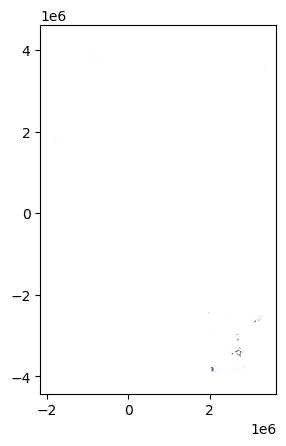

Processing CPIS Layers:  50%|█████     | 2/4 [00:45<00:43, 21.68s/it]

CPIS data for Arid aridity layer processed and saved to /home/waves/data/Africa_Irrigation/Data/Processed/Combined_CPIS_Aridity_Layers-shp/Combined_CPIS_Arid.shp


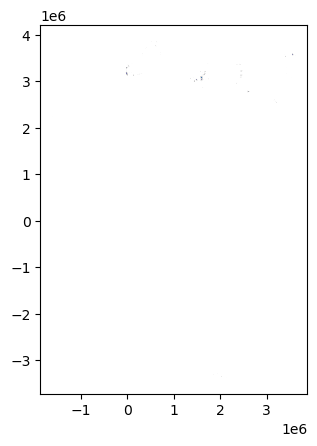

Processing CPIS Layers:  75%|███████▌  | 3/4 [00:53<00:15, 15.43s/it]

CPIS data for Hyper_Arid aridity layer processed and saved to /home/waves/data/Africa_Irrigation/Data/Processed/Combined_CPIS_Aridity_Layers-shp/Combined_CPIS_Hyper_Arid.shp


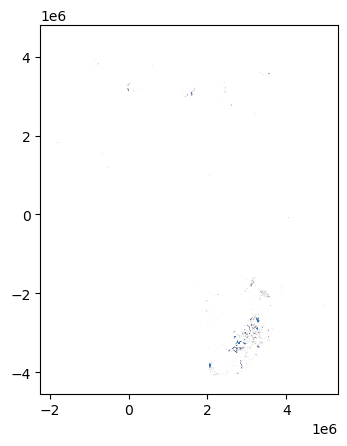

Processing CPIS Layers: 100%|██████████| 4/4 [01:24<00:00, 21.06s/it]

CPIS data for All aridity layer processed and saved to /home/waves/data/Africa_Irrigation/Data/Processed/Combined_CPIS_Aridity_Layers-shp/Combined_CPIS_All.shp


In [ ]:

def optimized_clip(CPIS_gdf, clip_gdf):
    # Create a unary union of the clip geometries
    clip_union = unary_union(clip_gdf.geometry)

    # Compute the centroids of the CPIS geometries
    CPIS_gdf['centroid'] = CPIS_gdf.geometry.centroid

    # Create a GeoDataFrame from the centroids
    centroids_gdf = gpd.GeoDataFrame(CPIS_gdf, geometry='centroid')

    # Use spatial join to filter geometries whose centroids intersect the clipping area
    clip_gdf = gpd.GeoDataFrame(geometry=[clip_union], crs=clip_gdf.crs)
    joined = gpd.sjoin(centroids_gdf, clip_gdf, how="inner", predicate="intersects")

    # Use the original geometries, but filtered by centroid intersection
    filtered_gdf = CPIS_gdf.loc[joined.index].copy()

    # Drop the centroid column to avoid multiple geometry columns
    filtered_gdf = filtered_gdf.drop(columns=['centroid'])

    # Rename 'Country Co' to 'ISO3'
    if 'Country Co' in filtered_gdf.columns:
        filtered_gdf = filtered_gdf.rename(columns={'Country Co': 'ISO3'})

    filtered_gdf.plot()
    plt.show()
    
    return filtered_gdf

def process_cpis_layer(layer_name, config, gdf_cpis_reproj):
    # Resolve the paths for the aridity shapefile and output file
    shp_path = resolve_path(config[f'Africa_{layer_name}_shp_path'])
    output_path = resolve_path(config[f'Combined_CPIS_{layer_name}_shp_path'])
    
    # Load the shapefile for the current aridity layer
    gdf_shp = gpd.read_file(shp_path)

    # Reproject the aridity shapefile to match the CRS of the CPIS data
    if gdf_shp.crs != gdf_cpis_reproj.crs:
        gdf_shp = gdf_shp.to_crs(gdf_cpis_reproj.crs)

    # Perform the optimized clip operation using spatial join with centroids
    gdf_cpis_filtered = optimized_clip(gdf_cpis_reproj, gdf_shp)

    # Save the filtered data to a new shapefile
    gdf_cpis_filtered.to_file(output_path, driver='ESRI Shapefile')

    print(f"CPIS data for {layer_name} aridity layer processed and saved to {output_path}")

# Load the main CPIS dataset
gdf_cpis_deg = gpd.read_file(resolve_path(config['Combined_CPIS_shp_path']))
print("Original CRS:", gdf_cpis_deg.crs)

# Reproject to the desired CRS (EPSG:3857)
gdf_cpis_reproj = gdf_cpis_deg.to_crs("EPSG:3857")
print("Reprojected CRS:", gdf_cpis_reproj.crs)

# Save the reprojected data (if needed)
gdf_cpis_reproj.to_file(resolve_path(config['Combined_CPIS_Reproj_shp_path']))

# Define the aridity layers
layers = ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']

# Iterate through each aridity layer and process the CPIS data with a progress bar
for layer in tqdm(layers, desc="Processing CPIS Layers"):
    process_cpis_layer(layer, config, gdf_cpis_reproj)


Filter the 'All' layer to SSA

In [11]:
gdf_cpis = gpd.read_file(resolve_path(config['Combined_CPIS_All_shp_path']))
SSA_gdf_cpis = gdf_cpis[gdf_cpis['ISO3'].isin(ssa_iso)]
SSA_gdf_cpis.to_file(resolve_path(config['SSA_Combined_CPIS_All_shp_path']))